In [1]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq

In [2]:
torch.cuda.is_available()

True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [4]:
# For reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## Generate dataset

The code currently loads a previously created dataset instead of creating a new one each time.

In [5]:
class FourierSeriesDataset(Dataset):
    def __init__(self, num_samples, num_points, max_terms=10):
        self.num_samples = num_samples
        self.num_points = num_points
        self.max_terms = max_terms
        self.x = torch.linspace(0, 2*np.pi, num_points, requires_grad=True)
        self.functions, self.derivatives = self.generate_data()

    def generate_data(self):
        functions = []
        derivatives = []

        for _ in range(self.num_samples):
            # Generate random complex coefficients
            n_terms = np.random.randint(1, self.max_terms + 1)
            c = torch.complex(torch.randn(2*n_terms+1), torch.randn(2*n_terms+1))

            # Compute function values
            y = self.complex_fourier_series(self.x, c)
            functions.append(y.detach().numpy())

            # Compute derivative
            dy_dx = torch.autograd.grad(y, self.x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
            derivatives.append(dy_dx.detach().numpy())

        return np.array(functions), np.array(derivatives)

    def complex_fourier_series(self, x, c, P=2*np.pi):
        result = torch.zeros_like(x, dtype=torch.complex64)
        for n in range(-len(c)//2, len(c)//2 + 1):
            result += c[n + len(c)//2] * torch.exp(1j * 2 * np.pi * n * x / P)
        return result.real

    def __len__(self):
        return self.num_samples

    def __getitem__(self, idx):
        return torch.FloatTensor(self.functions[idx]), torch.FloatTensor(self.derivatives[idx])

# Generate dataset
num_samples = 10000
num_points = 1000
# dataset = FourierSeriesDataset(num_samples, num_points)

# # Create DataLoader
# batch_size = 32
# dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# torch.save(dataset, 'derivative_dataset.pt')

    

## Load previously saved dataset

In [6]:
dataset = torch.load('derivative_dataset.pt')

In [7]:
from torch.utils.data import random_split
total_size = len(dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)
train_dataset, test_dataset = random_split(dataset, [train_size, test_size], generator=generator)

In [8]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

In [9]:
print(len(train_dataloader))
print(len(test_dataloader))

250
62


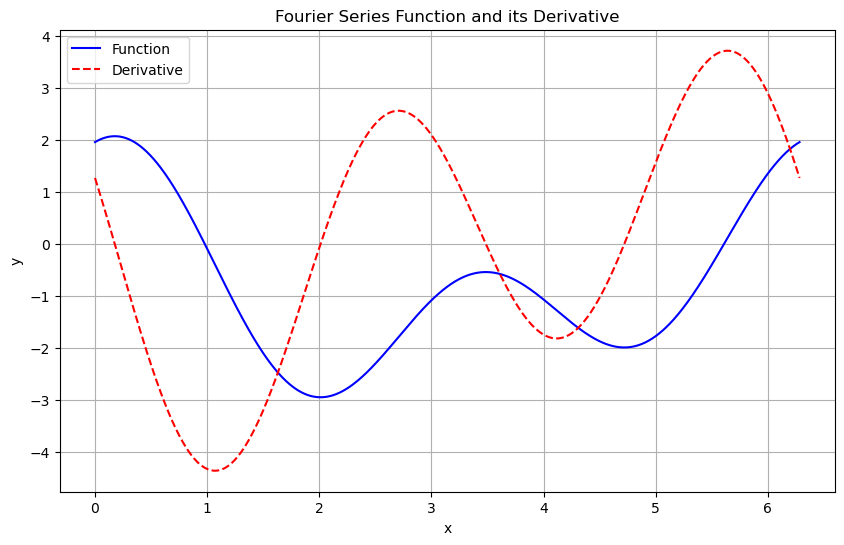

In [10]:
def plot_function_and_derivative(dataloader):
    # Get a single sample from the dataloader
    dataiter = iter(dataloader)
    function, derivative = next(dataiter)

    # Since we're dealing with batches, let's take the first item in the batch
    function = function[0].numpy()
    derivative = derivative[0].numpy()

    # Create x-axis values (assuming the domain is [0, 2π])
    x = torch.linspace(0, 2*torch.pi, len(function)).numpy()

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(x, function, label='Function', color='blue')
    plt.plot(x, derivative, label='Derivative', color='red', linestyle='--')
    
    plt.title('Fourier Series Function and its Derivative')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    
    plt.show()

# Example usage:
# Assuming you have already created your dataset and dataloader as before
# dataset = FourierSeriesDataset(num_samples, num_points)

def get_random_function(shuffle=True):
    return DataLoader(train_dataset, batch_size=1, shuffle=shuffle)

train_dataloader_viz = get_random_function(shuffle=False)
plot_function_and_derivative(train_dataloader_viz)

## Model Training

Create the model

In [11]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

# Initialize the model, loss function, and optimizer
model1 = SimpleCNN()
criterion = nn.MSELoss()
optimizer = optim.Adam(model1.parameters())

## Load in previously saved model weights from 300 epochs

In [12]:
model1.load_state_dict(torch.load('model_weights.pth'))

<All keys matched successfully>

## Training loop

In [13]:
# Training loop
train_losses = []
test_losses = []

num_epochs = 10
for epoch in range(num_epochs):
    model1.train()
    train_loss = 0.0
    test_loss = 0.0

    for batch_functions, batch_derivatives in train_dataloader:
        # Reshape input: [batch_size, 1, num_points]
        batch_functions = batch_functions.unsqueeze(1)
        batch_derivatives = batch_derivatives.unsqueeze(1)

        # Forward pass
        outputs = model1(batch_functions)
        loss = criterion(outputs, batch_derivatives)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_dataloader)

    model1.eval()
    with torch.no_grad():
        for b_test_functions, b_test_derivatives in test_dataloader:
            b_test_functions = b_test_functions.unsqueeze(1)
            b_test_derivatives = b_test_derivatives.unsqueeze(1)

            test_outputs = model1(b_test_functions)
            batch_test_loss = criterion(test_outputs, b_test_derivatives)

            test_loss += batch_test_loss.item()

    test_loss /= len(test_dataloader)

    train_losses.append(train_loss)
    test_losses.append(test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


# Save the model
# Don't save the model right now
# torch.save(model.state_dict(), 'model_weights.pth')

# To load the model later:
# model = SimpleCNN()
# model.load_state_dict(torch.load('fourier_derivative_model.pth'))
# model.eval()

print("Training finished!")

Epoch [1/10], Train Loss: 0.3736, Test Loss: 0.0309
Epoch [2/10], Train Loss: 0.0263, Test Loss: 0.0308
Epoch [3/10], Train Loss: 0.0278, Test Loss: 0.0722
Epoch [4/10], Train Loss: 0.0624, Test Loss: 0.0306
Epoch [5/10], Train Loss: 0.0261, Test Loss: 0.0308
Epoch [6/10], Train Loss: 0.0369, Test Loss: 0.0386
Epoch [7/10], Train Loss: 0.0640, Test Loss: 0.1504
Epoch [8/10], Train Loss: 0.0435, Test Loss: 0.0733
Epoch [9/10], Train Loss: 0.0308, Test Loss: 0.0403
Epoch [10/10], Train Loss: 0.0700, Test Loss: 0.0512
Training finished!


In [14]:
def plot_losses(train_losses, test_losses, xmin=None, ymax=None):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    # if xmin:
    #     plt.xlim(xmin=xmin)
    #     min_loss = min(min(train_losses[xmin-1:]), min(test_losses[xmin-1:]))
    #     max_loss = max(max(train_losses[xmin-1:]), max(test_losses[xmin-1:]))
    #     plt.ylim(min_loss, max_loss)
    # if ymax:
    #     plt.ylim(ymax=ymax)
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
# plot_losses(train_losses=train_losses, test_losses=test_losses)

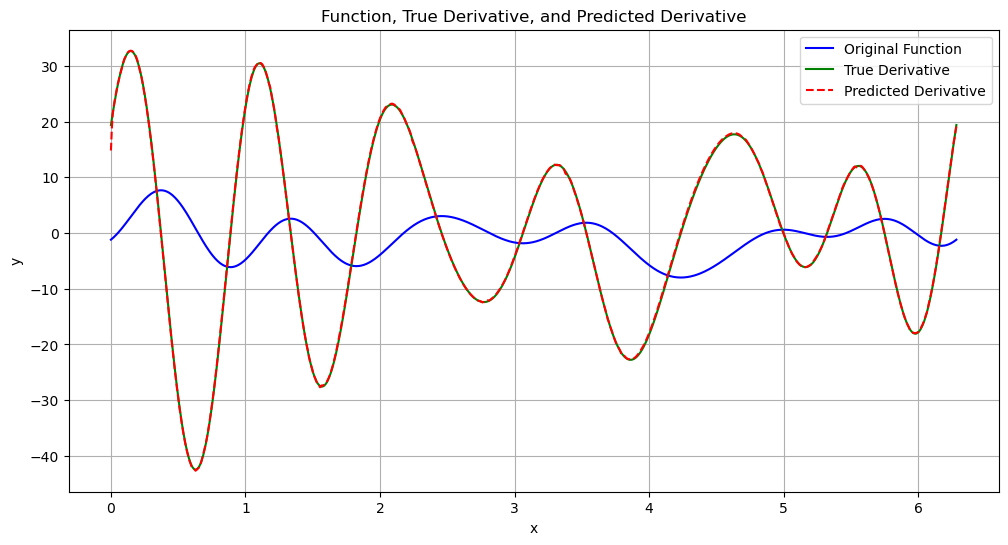

In [16]:
model1.eval()  # Set the model to evaluation mode

train_dataloader_viz = get_random_function(shuffle=True)
# Get a random sample from the dataloader
dataiter = iter(train_dataloader_viz)
function, true_derivative = next(dataiter)

# Reshape the input for the model
function = function.unsqueeze(1)  # Add channel dimension

# Make prediction
with torch.no_grad():
    predicted_derivative = model1(function)

# Convert tensors to numpy arrays for plotting
x = torch.linspace(0, 2*torch.pi, 1000).numpy()
function = function.squeeze().numpy()
true_derivative = true_derivative.squeeze().numpy()
predicted_derivative = predicted_derivative.squeeze().numpy()

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(x, function, label='Original Function', color='blue')
plt.plot(x, true_derivative, label='True Derivative', color='green')
plt.plot(x, predicted_derivative, label='Predicted Derivative', color='red', linestyle='--')
plt.title('Function, True Derivative, and Predicted Derivative')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()